<a href="https://colab.research.google.com/github/RegiRau/Vein_Segmentation/blob/main/Test_Vein_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
# Choose run_number and training number
import os
run_number = 'run_1'
training_number = 2

In [4]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K


#convolutional block
def conv_block(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

        
    #skip connection    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])       
    return respath


#gating signal for attention unit
def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

#attention unit/block based on soft attention
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x) 
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) 
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)                          
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock

#Attention U-NET
def attentionunet(input_shape, dropout=0.2, batchnorm=True):
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape) 

    # Downsampling layers    
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers    
    gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
    att_5 = attention_block(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    gating_4 = gatingsignal(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
   
    gating_3 = gatingsignal(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    gating_2 = gatingsignal(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)
    
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()       
    return model    

In [5]:
from tensorflow.keras import backend as K
from sklearn.metrics import jaccard_score,confusion_matrix


def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)
 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  
def accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    return acc
  
def IoU(y_true, y_pred, labels = [0, 1]):
   IoU = []
   for label in labels:
      jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='binary')
      IoU.append(jaccard)     
   return np.mean(IoU) 

In [7]:
#loading model architectures
from tensorflow.keras.optimizers import Adam
IMG_CHANNELS = 1
SIZE_X = 1632
SIZE_Y = 1216
IMG_HEIGHT = SIZE_Y
IMG_WIDTH = SIZE_X
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = attentionunet(input_shape)

model.compile(optimizer = Adam(learning_rate = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1216, 1632,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d_39 (Conv2D)             (None, 1216, 1632,   160         ['input_2[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization_27 (BatchN  (None, 1216, 1632,   64         ['conv2d_39[0][0]']              
 ormalization)                  16)                                                         

Shape of x_test:  (5, 1216, 1632, 1)
Shape of y_test:  (5, 1216, 1632, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify 

Average accuracy is 1.0
mean IoU is 0.9562899090557275


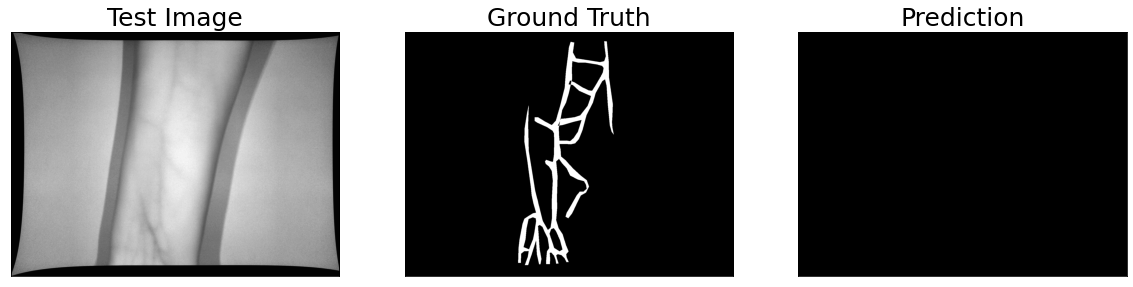

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(0)

# CLAHE
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized

SIZE_X = 1632
SIZE_Y = 1216

model.load_weights('/content/gdrive/MyDrive/Vein_Segmentation_Models/' + run_number + '/model_' + run_number[4] + '_training' + str(training_number) + '.hdf5') #loading weights

import numpy as np
x_test = np.load('/content/gdrive/MyDrive/train_test_split/' + run_number + '/x_test.npy')
y_test = np.load('/content/gdrive/MyDrive/train_test_split/' + run_number + '/y_test.npy')

print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

from sklearn.metrics import jaccard_score,confusion_matrix

testimg = []
ground_truth = []
prediction = []
global_IoU = []
global_accuracy = []

for idx in range(5):#x_test.shape[0]):
    test_img = x_test[idx, :, :, 0]
    testimg.append(test_img)
    test_img_norm = (test_img.astype('float32')) / 255.
    test_img_norm = np.expand_dims(np.array(test_img_norm), axis=-1)
    test_img_input = np.expand_dims(test_img_norm, 0)
    test_img_prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.5).astype(
        np.uint8)  # predict on single patch
    prediction.append(test_img_prediction)


    groundtruth = y_test[idx, :, :, 0]
    groundtruth[groundtruth > 0.0] = 1.0
    groundtruth = np.array(groundtruth, dtype="uint8")
    ground_truth.append(groundtruth)

    y_true = groundtruth # 1 and 0
    y_pred = test_img_prediction  # 1 and 0
    labels = [0, 1]
    IoU = []  #Intersection over Union -> Schwellenwert, um zu ermitteln, ob ein vorhergesagtes Ergebnis ein
            #True Positive oder ein False Positive ist

    for label in labels:
      jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='weighted')
      IoU.append(jaccard)
    IoU = np.mean(IoU) #jacard/IoU of single image
    global_IoU.append(IoU)

    cm=[]
    accuracy = []
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
    accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]) #accuracy of single image
    #cm[0,0]: true negatives, c[1,1]: true positives, c[1,0]: false negatives, c[0,1]: false positives
    global_accuracy.append(accuracy)


avg_acc =  np.mean(global_accuracy)
mean_IoU = np.mean(global_IoU)

print('Average accuracy is',avg_acc)
print('mean IoU is',mean_IoU)


#checking segmentation results
import random
test_img_number = random.randint(0, 5) #len(testimg))
plt.figure(figsize=(20, 18))
plt.subplot(231)
plt.title('Test Image', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.imshow(testimg[test_img_number], 'gray')
plt.subplot(232)
plt.title('Ground Truth', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.imshow(ground_truth[test_img_number],cmap='gray')
plt.subplot(233)
plt.title('Prediction', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.imshow(prediction[test_img_number],cmap='gray')

plt.show()

In [ ]:
print('x_test shape', x_test.shape)

test_images_norm = x_test[:3, :, :, 0]/255.
print('test_images shape ', test_images_norm.shape)

test_imgs_exp = np.expand_dims(np.array(test_images_norm), axis=-1)
test_imgs_input = test_imgs_exp.copy()
#test_imgs_input = np.expand_dims(test_imgs_exp, 0)

predictions = (model.predict(test_imgs_input)[:3, :, :, 0] > 0.5).astype(np.uint8)
print("predictions shape:", predictions.shape)